## LSTM모델을 통한 유동인구 예측(simple_ver.)

간단한 구조의 LSTM model을 활용하여 유동인구 데이터를 예측

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [31]:
from tensorflow.python.keras.layers import LSTM 
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.layers import Dense 
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [50]:
df=pd.read_csv("C:/Users/wnduq/Desktop/유동인구_부전1동.csv",encoding='euc-kr')
df.shape

(25536, 17)

In [ ]:
df["남10대"].plot()
df["남50대"].plot()
df["여20대"].plot()

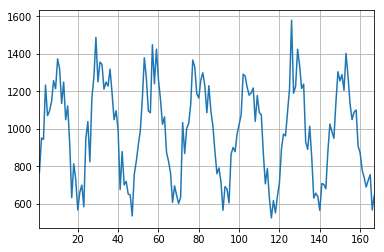

In [51]:
#일주일치
df["남10대"][1:24*7].plot(grid=True)

살짝 과적합되는 느낌...
(1. 배치사이즈 조절
 2. dropout 적용
 3. ...)

In [63]:
##데이터
#scaling
scaler = MinMaxScaler(feature_range=(0, 1))
tmp_data = scaler.fit_transform(df["남10대"][:,None])

#2일치로 1시간 예측(슬라이드 원도우)
look_back = 24*2

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data={}
data=create_dataset(tmp_data,look_back)

x_data=data[0]
y_data=data[1]
num_data = len(x_data)



##test,train 분할(1년치만 학습)

num_train = 24*28*24
num_test = 24*28*1

x_train = x_data[0:num_train]
x_test = x_data[num_train:num_train+num_test-1]

y_train = y_data[0:num_train]
y_test = y_data[num_train:num_train+num_test-1]

num_x_signals = x_data.shape[1]
num_x_signals

num_y_signals = 1
num_y_signals



##모델링(simple_ver.)



K.clear_session()
   
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(24*2, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()



x_train = x_train.reshape(x_train.shape[0],24*2,1)


##callback
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./last_M/',histogram_freq=0,write_graph=True)


model.fit(x_train, y_train, epochs=100,
          batch_size=50, verbose=1, callbacks=[early_stop,callback_tensorboard])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16128/16128 [==============================] - 42s 3ms/sample - loss: 0.0112
Epoch 2/100
16128/16128 [==============================] - 43s 3ms/sample - loss: 0.0043
Epoch 3/100
16128/16128 [==============================] - 45s 3ms/sample - loss: 0.0031
Epoch 4/100
16128/16128 [==============================] - 42s 3ms/sample - loss: 0.0022
Epoch 5/100
16128/16128 [==============================] - 42s 3ms/sample - loss: 0.0020
Epoch 6/100
16128/16128 [==============================] - 44s 3ms/samp

# 학습이후 예측값과 실제값을 비교하여 본다. 
그림을 통한 비교

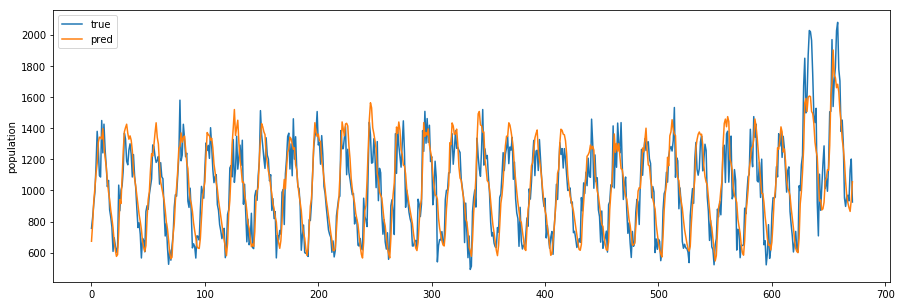

In [70]:
##예측

def plot_comparison(start_idx, length, train):

    if train:
        x = x_train
        y_true = y_train
    else:
        x = x_test.reshape(x_test.shape[0],24*2,1)
        y_true = y_test
    end_idx = start_idx + length
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    y_pred = model.predict(x)
    
   
    signal_pred = scaler.inverse_transform(y_pred)
    signal_true = scaler.inverse_transform(y_true)
    plt.figure(figsize=(15,5))
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
        
    plt.ylabel("population")
    plt.legend()
    plt.show()

###training set에대해
plot_comparison(0, length=24*28, train=True)


training set에 대한 적합을 본다.

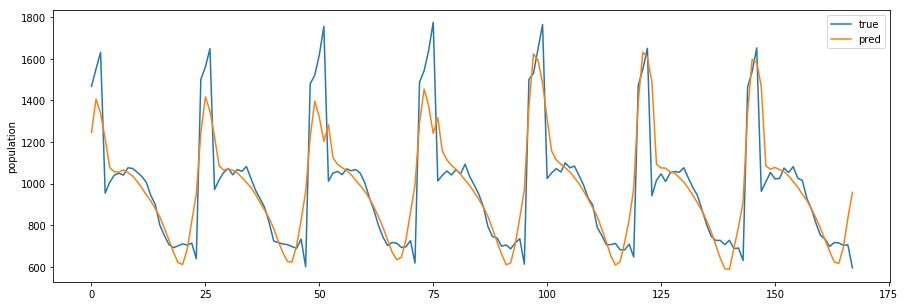

In [69]:
###predict
plot_comparison(0, length=24*7, train=False)

test set에 대한 predict값과 실제값을 비교하여 본다.